# Abstractive Text Summarization


In [ ]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

: 

In [ ]:
!pip install -q contractions==0.0.48

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 12.2 MB/s eta 0:00:00


In [ ]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


## 🪂 Getting the data

In [ ]:
import csv

with open("news_summary_more.csv", "r") as f:
    reader = csv.reader(f)
    data = list(reader)

# df = pd.DataFrame(data)
# df2 = pd.DataFrame(data2)
df1 = pd.DataFrame(data[1:], columns=data[0])


In [ ]:
with open("news_summary.csv", "r", encoding="latin-1") as f:
    reader = csv.reader(f)
    data = list(reader)
df2 = pd.DataFrame(data[1:], columns=data[0])


In [ ]:
df1.sample(5)

,headlines,text
3274,Gold mine dug by villagers collapses in Afghan...,At least 30 people were killed in the collapse...
1520,We're far from being partners: Russia on ties ...,"Russia and Japan are still ""far from being par..."
1458,"Facebook testing 'LOL' feature for memes, vira...","Facebook is testing 'LOL' feature, a dedicated..."
3135,Billionaire offers â¹6.5 crore to 100 people ...,A tweet by billionaire and Japan's largest clo...
170,Ghalib's work could only have found meaning in...,While speaking about the work of Urdu poet Mir...


In [ ]:
df2.sample(5)

,author,date,headlines,read_more,text,ctext
266,Saloni Tandon,"30 Jul 2017,Sunday",Harmanpreet asks PM Modi if he has a clothes d...,http://www.hindustantimes.com/cricket/indian-w...,India Women cricketer Harmanpreet Kaur asked N...,Prime Minister Narendra Modi on Thursday hoste...
155,Parmeet Kaur,"01 Aug 2017,Tuesday",Woman's headless body found in a suitcase in M...,http://indiatoday.intoday.in/story/navi-mumbai...,"Headless body of a woman, suspected to be in h...",Dead body of a woman aged around 20 to 25 was ...
227,Parmeet Kaur,"31 Jul 2017,Monday","Delhi among 29 cities, towns highly vulnerable...",http://www.hindustantimes.com/india-news/delhi...,Twenty-nine Indian cities and towns including ...,"Twenty-nine Indian cities and towns, including..."
267,Dishant Sharma,"30 Jul 2017,Sunday",Completing antibiotics course not necessary: S...,https://www.theguardian.com/society/2017/jul/2...,A new study has found the rule that patients m...,Telling patients to stop taking antibiotics wh...
68,Sumedha Sehra,"02 Aug 2017,Wednesday",What gifts did PM Narendra Modi take home this...,http://www.hindustantimes.com/india-news/gifts...,PM Narendra Modi took a wristwatch by British ...,"Prime Minister Narendra Modi, his fans and fol..."


In [ ]:
df2_columns = df2.columns.tolist()
df2_columns.remove('headlines')
df2_columns.remove('text')
df2.drop(df2_columns, axis='columns', inplace=True)

df = pd.concat([df1, df2], axis='rows')
del df1, df2

# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 5260


,headlines,text
3245,Karnataka govt wants development-free corrupti...,Prime Minister Narendra Modi on Friday critici...
3136,Was harassed by my coworkers: Man who got nake...,A male passenger who stripped naked and walked...
2493,3 workers killed after being run over by train...,At least three workers were killed on Sunday a...
1906,"When I play int'l cricket, I don't need to sil...",Talking about his critics after scoring 106(31...
1291,Paes crashes out of Aus Open after 1st round l...,Indian tennis player Leander Paes and his Mexi...


The `headlines` column will be treated as `summary` for the text.

## Data preparation

In [ ]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all can not expand contractions id think'

In [ ]:
# Converting to lowercase
df.text = df.text.apply(str.lower)
df.headlines = df.headlines.apply(str.lower)

df.sample(5)

,headlines,text
2550,govinda's nephew janmendra passes away after h...,actor govinda's 34-year-old nephew janmendra a...
3018,you helped me find my strength: husband to son...,wishing sonali bendre on her 44th birthday on ...
547,govt has prepared revival plan for air india: ...,union minister jayant sinha has said the gover...
3896,can't ask teachers for duties outside rte act:...,the delhi high court has said that municipal c...
3778,bihar seat-share example of bjpâs insecurity...,"hitting out at bjp, rajasthan deputy cm sachin..."


In [ ]:
df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)
df.sample(5)

,headlines,text
5076,ex-swiss banker convicted for selling secret t...,a swiss court has convicted a former ubs banke...
110,it will happen when it has to happen: deepika ...,talking about motherhood and planning a family...
2205,wifi at indian railway stations better than lo...,googles head of connectivity in india recently...
4372,woman turns apple airpods into earrings to avo...,"gabrielle reilly, a 22-year-old us woman, crea..."
5258,shakal dekh ke baahar kar dete the: kartik on ...,"kartik aaryan, while talking about his struggl..."


In [ ]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))


# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [ ]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [ ]:
!pip install nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# prompt: Apply lemmetization on data

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    text = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    return ' '.join(lemmatized_words)

df.headlines = df.headlines.apply(lemmatize_text)
df.text = df.text.apply(lemmatize_text)
df.sample(5)


,headlines,text
4500,pakistan claim it shot down indian spy quadcopter,"the pakistan army shot down an ""indian spy qua..."
691,tn minister quits after conviction in 98 stone...,tamil nadu sport minister p balakrishna reddy ...
4605,angad revealed everything meant to be hidden o...,"neha dhupia ha said her husband, actor angad b..."
3971,divyanka called out for wearing copy of sabyas...,television actress divyanka tripathi ha been c...
2561,17 child injured a school bus overturn in hima...,a many a 17 child were injured after a bus car...


In [ ]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [ ]:
df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)
df.sample(5)

,headlines,text
3217,pandyas apology drafted agency doe look sincer...,coa chief vinod rai themail dated ary mentione...
3509,indianorigin engineer lead tech clean water ba...,indianorigin engineer srikanth singamaneniled ...
3251,make bumrah special learner gavaskar,praising pacer jasprit bumrah former indian cr...
3995,india fully operationalise chabahar port soon ...,union minister nitin gadkari tuesday said indi...
1434,desperate move stop fir pm bhushan cbi chief r...,rthemoval alok verma cbi chief senior suprthem...


In [ ]:
# saving the cleaned data
df.to_csv('cleaned_data.csv')

In [ ]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')

    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

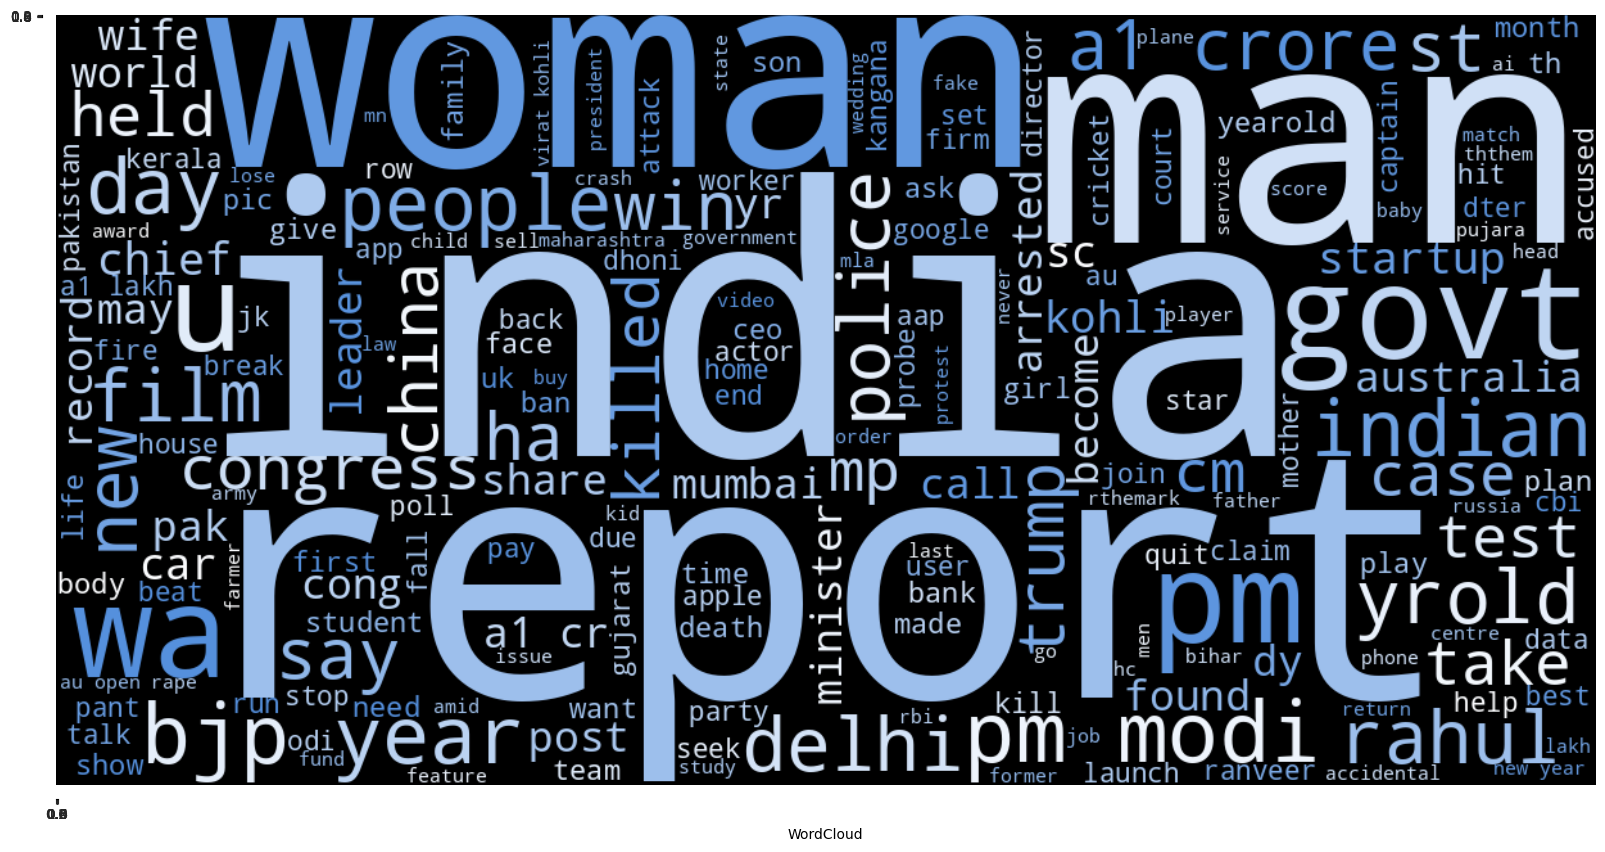

In [ ]:
plot_wordcloud(' '.join(df.headlines.values.tolist()), wc_blue_color_func)

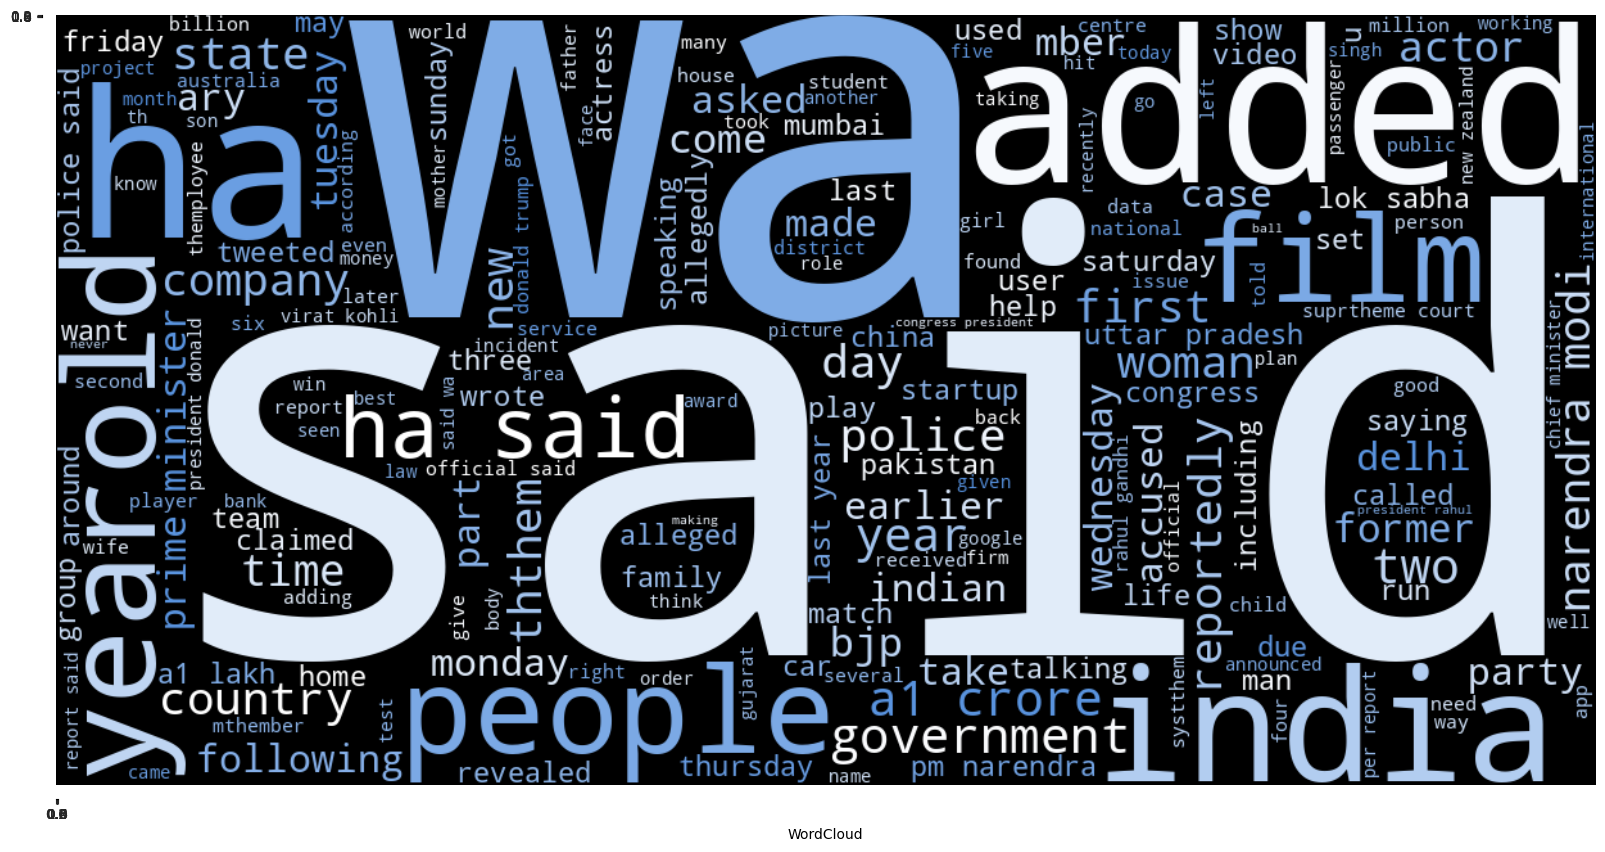

In [ ]:
plot_wordcloud(' '.join(df.text.values.tolist()), wc_blue_color_func)

Using a `start` and `end` tokens in `headlines(summary)` to let the learning algorithm know from where the headlines start's and end's.

In [ ]:
df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')

In [ ]:
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')

In [ ]:
df.sample(5)

,headlines,text
4609,sostok _START_ dr rthemoved woman kidney think...,u surgeon rthemoved woman kidney mistaking tum...
1417,sostok _START_ kohli break dravids yearold tes...,run knock australia first inning third test in...
4239,sostok _START_ jewellery worth a1l stolen kaly...,gang robbed gold silver jewellery worth a1 lak...
4640,sostok _START_ delhi airport operator levy xra...,delhi airport operator dial start charging air...
3469,sostok _START_ china economy grows last year s...,amid trade war us china gdp expanded slowest a...


Finding what should be the `maximum length` of text and headlines that will be feed or accepted by the learning algorithm.

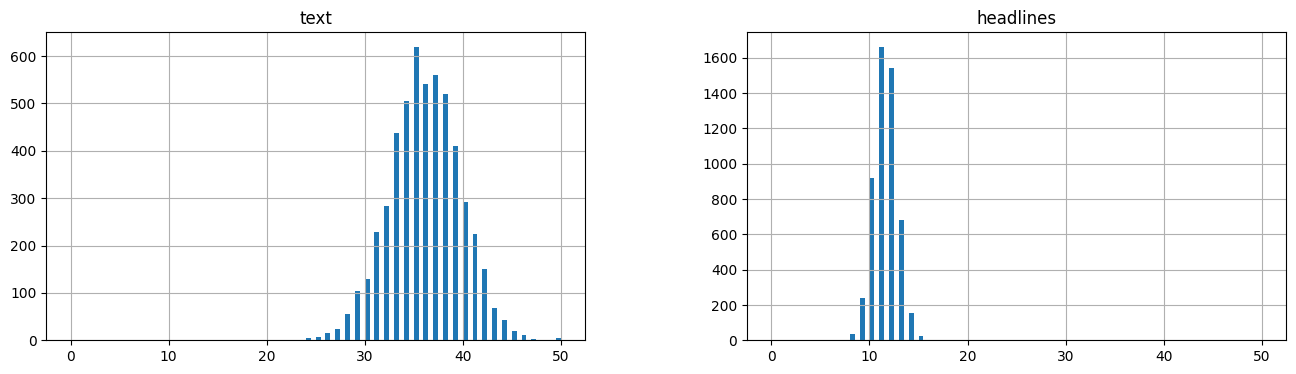

In [ ]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [ ]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(df.headlines, 26))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.text, 100))

1.0
1.0


In [ ]:
max_text_len = 100
max_summary_len = 26

In [ ]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['text'])
    cleaned_summary = np.array(df['headlines'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 5260


,text,summary
1966,talking samajwadi partyspbahusamaj partybsp al...,sostok _START_ alliance run till akhilesh knee...
4150,prime minister czech republic andrej babia ha ...,sostok _START_ czech pm hail make india initia...
674,india food regulator food safety standard auth...,sostok _START_ food regulator planning leftove...
3405,bangladeshi umpire tanvir ahmed whose wrong no...,sostok _START_ new intl cricket made mistake u...
4913,firstever one day international wa impromptu o...,sostok _START_ led birth one day international...


In [ ]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [ ]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

**Tokenizing text

In [ ]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 70.86, 'total_coverage': 13.04, 'count': 15266, 'total_count': 21543}


In [ ]:
# else use this
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [ ]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

21544


#Tokenizing headlines(Summary)

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 84.92, 'total_coverage': 23.14, 'count': 7405, 'total_count': 8720}


In [ ]:
# else use this
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [ ]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

8721


In [ ]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

#Modelling

In [ ]:
latent_dim = 240
embedding_dim = 300
num_epochs = 20

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-05-24 10:19:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-05-24 10:19:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-05-24 10:19:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = 'glove.6B.300d.txt'

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 400000 word vectors.
Converted 16576 words (4967 misses)
Found 400000 word vectors.
Converted 7454 words (1266 misses)


In [ ]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(21544, 300)
(8721, 300)


**Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.

In [ ]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    # with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False
        )(encoder_input)

        # encoder lstm 1
        encoder_lstm1 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        # encoder lstm 2
        encoder_lstm2 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=True
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # decoder lstm 1
        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states
        )

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

**Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.

In [ ]:
def build_seq2seq_model_with_bidirectional_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    # with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        decoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.2,
                name='decoder_lstm_1'
            ),
            name='decoder_bidirectional_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_bi_lstm(
            decoder_embedding, initial_state=encoder_final_states
            # decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_bi_lstm,
                    'dense': decoder_dense
                }
            }
        }

**Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

In [ ]:
def build_hybrid_seq2seq_model(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    # with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.2,
            name='decoder_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [ ]:
seq2seq = build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 300)             6463200   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 100, 240),           519360    ['embedding[0][0]']           
                              (None, 240),                                                    

If you want to change `model` then just change the `function name` above.

In [ ]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [ ]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

Use a `tuple` instead of `list` in `validation_parameter` in `model.fit()`, to know the reason reading this [post](https://stackoverflow.com/questions/61586981/valueerror-layer-sequential-20-expects-1-inputs-but-it-received-2-input-tensor).

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

In [ ]:
pickle.dump(history,open('history2.pkl','wb'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Plotting model's performance**

In [ ]:
# Provide accuracy for the trained model

history = pickle.load(open('/content/drive/MyDrive/proj2_model/history2.pkl','rb'))
acc = history.history['accuracy'][-1]
print(f'accuracy: {acc * 100:.2f}%')


accuracy: 71.43%


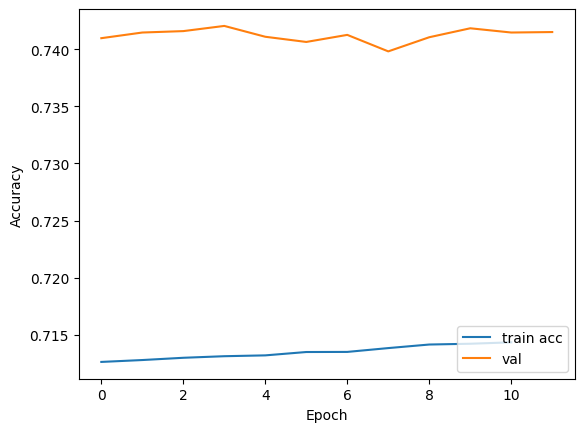

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

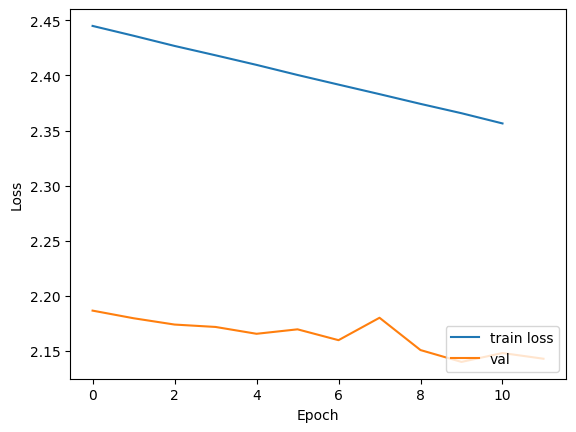

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

#Inference

In [ ]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
def build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
def build_seq2seq_model_with_bidirectional_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
def build_hybrid_seq2seq_model_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        #decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          6463200   
                                                                 
 lstm (LSTM)                 [(None, 100, 240),        519360    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 lstm_1 (LSTM)               [(None, 100, 240),        461760    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
Total params: 7444320 (28.40 MB)
Trainable params: 981120 (

In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, None, 300)            2616300   ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 240)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 240)]                0         []                            
                                                                                            

In [ ]:
decoder_model.layers[-3].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

Converting from `sequence to text` for model `with just LSTM's` and for model `with Bidirectional LSTM's`.

In [ ]:
def decode_sequence_seq2seq_model_with_just_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def decode_sequence_seq2seq_model_with_bidirectional_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [ ]:
def decode_sequence_hybrid_seq2seq_model(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values[:2]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [ ]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [ ]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [ ]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if len(l) % 3 != 0:
    while len(l) % 3 != 0:
        l.append(0)
print(l)

lst_i = 3
for i in range(0, len(l), 3):
    print(l[i:i + lst_i])

print(' '.join(['', 'james', 'ethan', '', 'tony']))
print(' '.join(' '.join(['', 'james', 'ethan', '', 'tony']).split()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 0, 0]
 james ethan  tony
james ethan tony


For predicting `unseen` data pass `decode_sequence` function for which you want to decode.

In [ ]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text])  # generator
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_text_len), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )  # to remove spaces that were added to make len(text_list) % max_text_len == 0

            _text = expand_contractions(_text)
            _text = clean_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
            # print(_text, '\n')

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_text_len), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

In [ ]:
history

#Predictions

In [ ]:
# Testing on training data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  responding vijender singhs comment chinese product last long chinese boxer singhs next opponent zulpikar maimaitiali said show vijender chinese capable shown india time againit time vijender learns lesson singh maimaitiali take double title bout st 
Original summary:  start show vijender chinese capable zulpikar end 
1/1 [==============================] - 0s 19ms/step
Predicted summary:   help dalchawal dalchawal cries allegations royal royal kiss fhrai fhrai girlfriend complaint royal hong rai shibasish struggling cries struggling cries filmmaker cries allegations royal royal

# 2 News:  yearold man named terry sanderson ha sued avenger actress gwyneth paltrow allegedly crashing skiing seeking million a1 crore damages lawsuit state actress got skied away knocking man leaving broken ribs incident reportedly took place utah us 
Original summary:  start man sue avenger actress gwyneth a1 crore ski crash end 
1/1 [==============================] - 0s 19ms/step
Predicted summary

In [ ]:
# prompt: Compute Rouge Score of the model

!pip install rouge
from rouge import Rouge

rouge = Rouge()
model_predictions = []
target_summaries = []

for i in range(0, 50):
    pred = decode_sequence_seq2seq_model_with_just_lstm(
        x_train_padded[i].reshape(1, max_text_len), encoder_model, decoder_model
    )
    model_predictions.append(pred)
    target_summaries.append(seq2summary(y_train_padded[i]))

scores = rouge.get_scores(model_predictions, target_summaries)

print("Rouge-1 F1 Score:", scores[0]["rouge-1"]["f"])
print("Rouge-2 F1 Score:", scores[0]["rouge-2"]["f"])
print("Rouge-L F1 Score:", scores[0]["rouge-l"]["f"])


1/1 [==============================] - 0s 29ms/step
Rouge-1 F1 Score: 0.0
Rouge-2 F1 Score: 0.0
Rouge-L F1 Score: 0.0


In [ ]:
# Testing on validation data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_val_padded[i]))
    print("Original summary: ", seq2summary(y_val_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_val_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  bengalurubased vernacular startup manch ha raised around a1 crore seed funding round wa led stellaris venture partner saw participation cofounder former flipkart executive sujeet ku among others founded pritam roy manch allows user discuss ask question express opinion various 
Original summary:  start bluru startup raise a1cr seed fund end 
1/1 [==============================] - 0s 28ms/step
Predicted summary:   club olympics product dona hrithiks hrithiks hrithiks hrithiks numaligarh book cat witchcraft sthemifinals sthemifinals sthemifinals sthemifinals maha office men wristband shuttlers mephedrone go hungarian allocates

# 2 News:  facebook testing feature dedicated feed consisting mtheme video viral content feature content topic like animals fails currently private beta around high school students facebook said still feature become part main app standalone app 
Original summary:  start facebook testing feature mthemes viral content end 
1/1 [============================

## 🎁 Saving the model

In [ ]:
# HDF5 format
model.save('model.h5')
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# prompt: import the saved model

from tensorflow.keras.models import load_model
model = load_model('model.h5')


## 🏌️‍♂️ Running all the 3 different models

After understanding how all the pieces work, running all the `3 models` to understand how it `performs` and its `results`.

**Here there 3 different training models**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**Inference methods for the 3 different learning models - just add `_inference` as `prefix`**
- `build_seq2seq_model_with_just_lstm_inference`
- `build_seq2seq_model_with_bidirectional_lstm_inference`
- `build_hybrid_seq2seq_model_inference`

**Decoding sequence for the 3 different learning models - just add `decode_sequence_` as `suffix`**
- `decode_sequence_build_seq2seq_model_with_just_lstm`
- `decode_sequence_build_seq2seq_model_with_bidirectional_lstm`
- `decode_sequence_build_hybrid_seq2seq_model`


In [ ]:
models_info = {
    'just_lstm': {
        'model': build_seq2seq_model_with_just_lstm,
        'inference': build_seq2seq_model_with_just_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_just_lstm
    },
    'bidirectional_lstm': {
        'model': build_seq2seq_model_with_bidirectional_lstm,
        'inference': build_seq2seq_model_with_bidirectional_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_bidirectional_lstm
    },
    'hybrid_model': {
        'model': build_hybrid_seq2seq_model,
        'inference': build_hybrid_seq2seq_model_inference,
        'decode_sequence': decode_sequence_hybrid_seq2seq_model
    }
}

**Model with just LSTMs**

In [ ]:
model_func = models_info['just_lstm']['model']
inference_func = models_info['just_lstm']['inference']
decode_sequence_func = models_info['just_lstm']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 100, 300)             6463200   ['input_6[0][0]']             
                                                                                                  
 input_7 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 lstm_3 (LSTM)               [(None, 100, 240),           519360    ['embedding_2[0][0]']         
                              (None, 240),                                                  

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/20
37/37 [==============================] - 58s 1s/step - loss: 4.5385 - accuracy: 0.5968 - val_loss: 2.5461 - val_accuracy: 0.6665 - lr: 0.0010
Epoch 2/20
37/37 [==============================] - 38s 1s/step - loss: 2.8058 - accuracy: 0.6368 - val_loss: 2.3179 - val_accuracy: 0.7017 - lr: 0.0010
Epoch 3/20
37/37 [==============================] - 39s 1s/step - loss: 2.6274 - accuracy: 0.6742 - val_loss: 2.1857 - val_accuracy: 0.7382 - lr: 0.0010
Epoch 4/20
37/37 [==============================] - 37s 983ms/step - loss: 2.5292 - accuracy: 0.7009 - val_loss: 2.1610 - val_accuracy: 0.7459 - lr: 0.0010
Epoch 5/20
37/37 [==============================] - 34s 933ms/step - loss: 2.4789 - accuracy: 0.7057 - val_loss: 2.1428 - val_accuracy: 0.7457 - lr: 0.0010
Epoch 6/20
37/37 [==============================] - 40s 1s/step - loss: 2.4602 - accuracy: 0.7061 - val_loss: 2.1166 - val_accuracy: 0.7462 - lr: 0.0010
Epoch 7/20
37/37 [==============================] - 33s 892ms/step - loss: 2

In [ ]:
pickle.dump(history,open('history3.pkl','wb'))

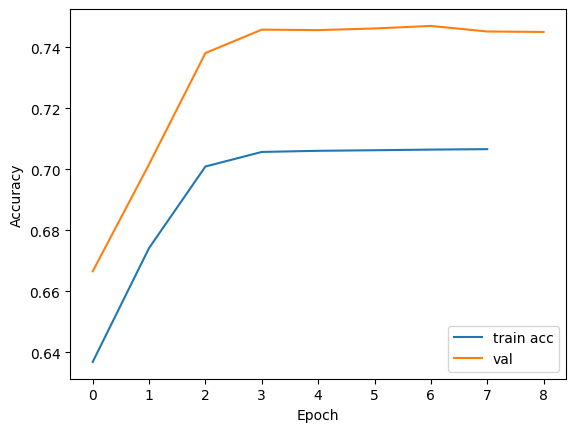

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

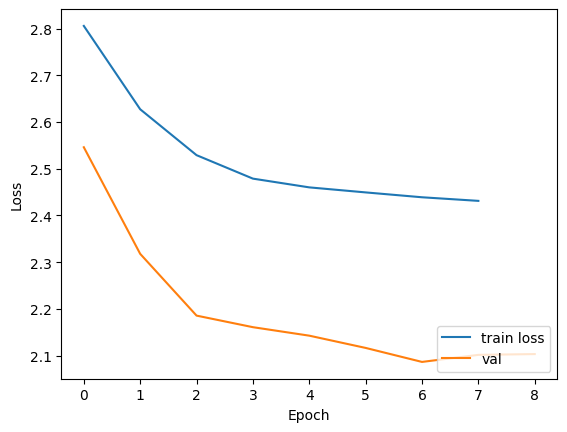

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 300)          6463200   
                                                                 
 lstm_3 (LSTM)               [(None, 100, 240),        519360    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 lstm_4 (LSTM)               [(None, 100, 240),        461760    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
Total params: 7444320 (28.40 MB)
Trainable params: 981120 (

In [ ]:
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, None, 300)            2616300   ['input_7[0][0]']             
                                                                                                  
 input_8 (InputLayer)        [(None, 240)]                0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 240)]                0         []                            
                                                                                            

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  responding vijender singhs comment chinese product last long chinese boxer singhs next opponent zulpikar maimaitiali said show vijender chinese capable shown india time againit time vijender learns lesson singh maimaitiali take double title bout st 
Original summary:  start show vijender chinese capable zulpikar end 
1/1 [==============================] - 0s 19ms/step
Predicted summary:   start india man india india end

# 2 News:  yearold man named terry sanderson ha sued avenger actress gwyneth paltrow allegedly crashing skiing seeking million a1 crore damages lawsuit state actress got skied away knocking man leaving broken ribs incident reportedly took place utah us 
Original summary:  start man sue avenger actress gwyneth a1 crore ski crash end 
1/1 [==============================] - 0s 19ms/step
Predicted summary:   start india man india india end

# 3 News:  recovering ankle injury forced australia tour yearold opener prithvi shaw said fit time indian prthemier league 

**Model with Bidirectional LSTMs**

In [ ]:
model_func = models_info['bidirectional_lstm']['model']
inference_func = models_info['bidirectional_lstm']['inference']
decode_sequence_func = models_info['bidirectional_lstm']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 encoder_embedding (Embeddi  (None, 100, 300)             6463200   ['input_11[0][0]']            
 ng)                                                                                              
                                                                                                  
 encoder_bidirectional_lstm  [(None, 100, 480),           1038720   ['encoder_embedding[0][0]']   
 _1 (Bidirectional)           (None, 240),                                                        
                              (None, 240),                    

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/20
37/37 [==============================] - 132s 3s/step - loss: 3.9358 - accuracy: 0.5916 - val_loss: 2.4584 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 2/20
37/37 [==============================] - 103s 3s/step - loss: 2.7462 - accuracy: 0.6625 - val_loss: 2.2468 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 3/20
37/37 [==============================] - 102s 3s/step - loss: 2.5808 - accuracy: 0.6956 - val_loss: 2.1315 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 4/20
37/37 [==============================] - 100s 3s/step - loss: 2.4802 - accuracy: 0.7047 - val_loss: 2.1012 - val_accuracy: 0.7476 - lr: 0.0010
Epoch 5/20
37/37 [==============================] - 97s 3s/step - loss: 2.4211 - accuracy: 0.7068 - val_loss: 2.0344 - val_accuracy: 0.7512 - lr: 0.0010
Epoch 6/20
37/37 [==============================] - 99s 3s/step - loss: 2.3787 - accuracy: 0.7091 - val_loss: 1.9993 - val_accuracy: 0.7534 - lr: 0.0010
Epoch 7/20
37/37 [==============================] - 102s 3s/step - loss: 2.343

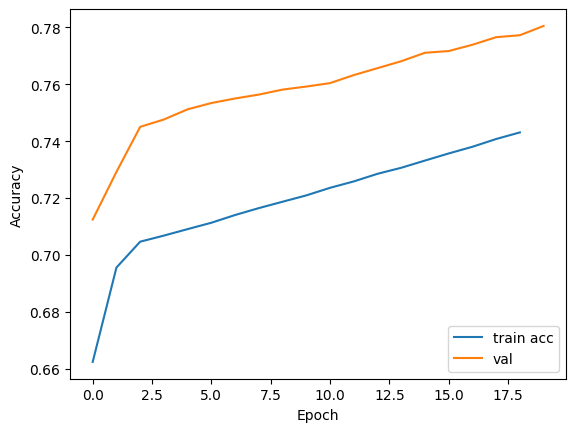

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

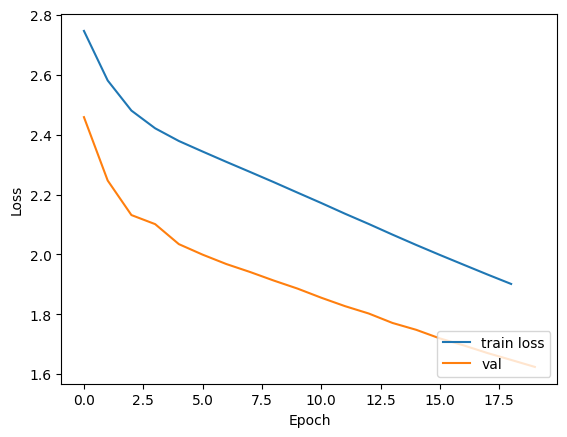

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 100)]             0         
                                                                 
 encoder_embedding (Embeddi  (None, 100, 300)          6463200   
 ng)                                                             
                                                                 
 encoder_bidirectional_lstm  [(None, 100, 480),        1038720   
 _1 (Bidirectional)           (None, 240),                       
                              (None, 240),                       
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 encoder_bidirectional_lstm  [(None, 100, 480),        1384320   
 _2 (Bidirectional)           (None, 240),                 

In [ ]:
decoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 decoder_embedding (Embeddi  (None, None, 300)            2616300   ['input_12[0][0]']            
 ng)                                                                                              
                                                                                                  
 input_13 (InputLayer)       [(None, 240)]                0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 240)]                0         []                      

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  responding vijender singhs comment chinese product last long chinese boxer singhs next opponent zulpikar maimaitiali said show vijender chinese capable shown india time againit time vijender learns lesson singh maimaitiali take double title bout st 
Original summary:  start show vijender chinese capable zulpikar end 
1/1 [==============================] - 0s 27ms/step
Predicted summary:   sostok trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump trump

# 2 News:  yearold man named terry sanderson ha sued avenger actress gwyneth paltrow allegedly crashing skiing seeking million a1 crore damages lawsuit state actress got skied away knocking man leaving broken ribs incident reportedly took place utah us 
Original summary:  start man sue avenger actress gwyneth a1 crore ski crash end 
1/1 [==============================] - 0s 32ms/step
Predicted summary:   sostok trump trump trump trump trump 